# Herschel Stripe 82 master catalogue
## Preparation of VISTA/CFHT Telescope / VIRCAM/WIRCAM Camera data

VISTA/CFHT Telescope / VIRCAM/WIRCAM Camera VICS82 catalogue: the catalogue comes from `dmu0_VICS82`.

The catalogue is described here: https://arxiv.org/pdf/1705.05451.pdf

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band.
- The auto magnitude to be used as total magnitude .



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
1407877 (Mon Feb 4 12:56:29 2019 +0000) [with local modifications]
This notebook was executed on: 
2021-04-28 17:36:24.358151


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, ebv

from herschelhelp.database import get_filters

/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/raphaelshirley/miniconda3/envs/herschelhelp_internal/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "vics82_ra"
DEC_COL = "vics82_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'VICS82ID': "vics82_id",
        'ALPHA_J2000': "vics82_ra",
        'DELTA_J2000': "vics82_dec",
        'CLASS_STAR':  "vics82_stellarity",
        'MAG_AUTO': "m_vics82_ks", 
        'MAG_APER': "m_ap_vics82_ks", 
        'SNR_WIN':'snr_ks',
        'JMAG_AUTO': "m_vics82_j", 
        'JMAG_APER': "m_ap_vics82_j", 
        'JSNR_WIN':'snr_j',
        'IMAGE': 'image_name',
        
})

#No error column?

catalogue = Table.read("../../dmu0/dmu0_VICS82/data/VICS82_FULL_SDSS_FEB2017_K22_HELP-coverage_intIDs.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

#replace list of aperture magnitudes with appropriate choice from list
# Apertures (1", 1.5", 2", 2.5" and 3"
catalogue["m_ap_vics82_j"] = catalogue["m_ap_vics82_j"][:, 2]
catalogue["m_ap_vics82_ks"] = catalogue["m_ap_vics82_ks"][:, 2]
#catalogue["m_ap_vics82_j"]  = [el[0] for el in catalogue["m_ap_vics82_j"] ]
#catalogue["m_ap_vics82_j"]  = [el[0] for el in catalogue["m_ap_vics82_j"] ]

In [5]:
catalogue['snr_ks'][(catalogue['snr_ks']<-98)|(catalogue['snr_ks']>1.e28)]=np.nan
catalogue['snr_j'][(catalogue['snr_j']<-98)|(catalogue['snr_j']>1.e28)]=np.nan

In [6]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        # Add err col with all nan values because errors absent
        errcol = "merr{}".format(col[1:])
        #nan_values = np.empty(len(catalogue))
        #nan_values[:] = np.NAN
        #catalogue.add_column(Column(nan_values, name=errcol))
        catalogue[errcol]= (2.5 / np.log(10) * (1/(
            catalogue['snr_{}'.format(col.split('_')[-1])]
        )))
        # Some object have a magnitude to 0 or 99., we suppose this means missing value
        mask = ((catalogue[col] <= 0) |
                (catalogue[col] > 50.) |
                (catalogue[errcol] <= 0) |
                (catalogue[errcol] > 100)) 
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan  
        

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        #catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        #catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        catalogue["f{}".format(col[1:])]=flux* 1.e6
        catalogue["f{}".format(errcol[1:])]=error* 1.e6
        
        # Band-flag column
        if "ap" not in col:
            #catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
            catalogue["flag{}".format(col[1:])]=np.zeros(len(catalogue), dtype=bool)
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

We have assumed that the SNR columns are equal to log10(s/n) so here we plot the values to check they behave as expected

(27, 10)

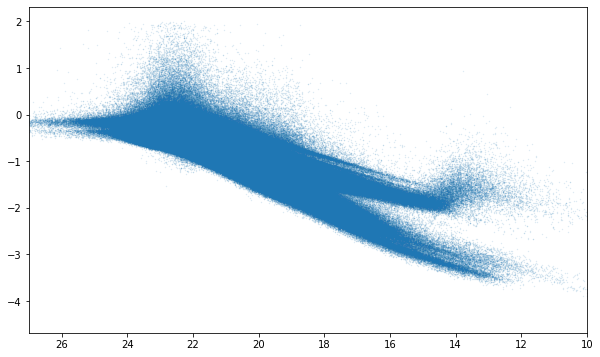

In [7]:
plt.scatter(catalogue['m_vics82_ks'],np.log10(catalogue['merr_vics82_ks']),s=0.1,alpha=0.2, rasterized=True)
plt.xlim([27,10])

In [8]:
catalogue[:10]

vics82_id,vics82_ra,vics82_dec,vics82_stellarity,m_vics82_ks,m_ap_vics82_ks,snr_ks,m_vics82_j,m_ap_vics82_j,snr_j,image_name,merr_vics82_ks,f_vics82_ks,ferr_vics82_ks,flag_vics82_ks,merr_ap_vics82_ks,f_ap_vics82_ks,ferr_ap_vics82_ks,merr_vics82_j,f_vics82_j,ferr_vics82_j,flag_vics82_j,merr_ap_vics82_j,f_ap_vics82_j,ferr_ap_vics82_j
bytes30,float64,float64,float64,float64,float32,float64,float64,float32,float64,bytes30,float64,float64,float64,bool,float64,float32,float64,float64,float64,float64,bool,float64,float32,float64
VICS82J000000.00-002426.2,4.385032055242988e-07,-0.40727797225957657,0.43904849886894226,23.114229202270508,24.52703,2.070167064666748,nan,nan,nan,C.10.Ks.fits,0.5244679153143176,2.062093337614567e-06,9.960999635295227e-07,False,0.5244679153143176,5.612902e-07,2.711328241124814e-07,nan,nan,nan,False,nan,nan,nan
VICS82J000000.00+001719.7,1.1118993593628446e-06,0.2887964581499206,0.3938422203063965,nan,nan,-1.6813032627105713,nan,nan,nan,C.05.Ks.fits,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan
VICS82J000000.00-000635.7,3.2315005539240715e-06,-0.10991359331608616,0.034445151686668396,23.537975311279297,25.524261,2.542707681655884,nan,nan,nan,C.10.Ks.fits,0.4270000097105409,1.3957571956810898e-06,5.489255433295159e-07,False,0.4270000097105409,2.2402426e-07,8.810460506924513e-08,nan,nan,nan,False,nan,nan,nan
VICS82J000000.00-000912.8,3.3816919030593695e-06,-0.15354172727559326,0.037895578891038895,22.976335525512695,23.439507,2.482875347137451,nan,nan,nan,C.10.Ks.fits,0.43728985670178444,2.3413470355312247e-06,9.429982210869358e-07,False,0.43728985670178444,1.5282607e-06,6.155204755765927e-07,nan,nan,nan,False,nan,nan,nan
VICS82J000000.00-001700.9,3.499298202314094e-06,-0.28359163112639757,0.35829970240592957,21.376319885253906,21.210651,4.705813884735107,nan,nan,nan,C.09.Ks.fits,0.23072230040377936,1.0220497725142302e-05,2.171887366454489e-06,False,0.23072230040377936,1.1905274e-05,2.5299075857158593e-06,nan,nan,nan,False,nan,nan,nan
VICS82J000000.00-003721.0,4.284605414239806e-06,-0.6224911028485363,0.36098235845565796,nan,nan,-0.1949475109577179,nan,nan,nan,C.10.Ks.fits,nan,nan,nan,False,nan,nan,nan,nan,nan,nan,False,nan,nan,nan
VICS82J000000.00-001634.9,5.293227616220975e-06,-0.27636138378447145,0.8169975876808167,18.51028060913086,18.829252,18.819053649902344,19.576915740966797,19.9758,11.597026824951172,C.09.Ks.fits,0.057693453930068556,0.00014318177973365786,7.608341120511171e-06,False,0.057693453930068556,0.00010673303,5.671541001241167e-06,0.09362194475761254,5.3608505931744774e-05,4.622607737390525e-06,False,0.09362194475761254,3.7126174e-05,3.201352664647881e-06
VICS82J000000.00-001758.2,5.900975452277635e-06,-0.2995030461876056,0.498833566904068,21.377437591552734,21.216852,4.944769859313965,nan,nan,nan,C.09.Ks.fits,0.21957264658395326,1.02099816930633e-05,2.064804224170673e-06,False,0.21957264658395326,1.1837469e-05,2.393937405009589e-06,nan,nan,nan,False,nan,nan,nan
VICS82J000000.00-010228.5,6.697762784724226e-06,-1.0412517871798377,0.9763750433921814,17.708951950073242,17.803595,22.321577072143555,17.699819564819336,17.873209,29.067089080810547,C.10.Ks.fits,0.04864065837503414,0.00029951544332286115,1.3418202591816174e-05,False,0.04864065837503414,0.00027451236,1.2298071547867426e-05,0.03735276696402697,0.0003020453638651109,1.0391317927480896e-05,False,0.03735276696402697,0.00025746386,8.857572777028166e-06


In [9]:
catalogue.remove_column('snr_j')
catalogue.remove_column('snr_ks')

In [10]:
for c in catalogue.colnames:
    try:
        print(c,catalogue[c].fill_value)
        if catalogue[c].fill_value > 1.e10:
            catalogue[c].fill_value=np.nan
        print(c,catalogue[c].fill_value)
    except:
        pass
catalogue=catalogue.filled()

vics82_id b'N/A'
vics82_ra 1e+20
vics82_ra nan
vics82_dec 1e+20
vics82_dec nan
vics82_stellarity 1e+20
vics82_stellarity nan
m_vics82_ks 1e+20
m_vics82_ks nan
m_ap_vics82_ks 1e+20
m_ap_vics82_ks nan
m_vics82_j 1e+20
m_vics82_j nan
m_ap_vics82_j 1e+20
m_ap_vics82_j nan
image_name b'N/A'
merr_vics82_ks 1e+20
merr_vics82_ks nan
merr_ap_vics82_ks 1e+20
merr_ap_vics82_ks nan
merr_vics82_j 1e+20
merr_vics82_j nan
merr_ap_vics82_j 1e+20
merr_ap_vics82_j nan


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [11]:
SORT_COLS = ['m_ap_vics82_j', 'm_ap_vics82_ks']
FLAG_NAME = 'vics82_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 15318703 sources.
The cleaned catalogue has 13914747 sources (1403956 removed).
The cleaned catalogue has 1239720 sources flagged as having been cleaned


## Determination of camera used
Using the service at https://apps.automeris.io/wpd/ I extracted positions from Figure 2 in the VICS82 paper.

![VICS82](../../dmu0/dmu0_VICS82/regions.png)

The positions from right to left are below in decimal hours in x and decimal degrees in y:

<pre>
positions= [
    [-0.3135593220338988, -0.0710346572223628],
    [0.8983050847457625, 0.06283835061978316],
    [0.9915254237288131, 0.004249936756892225],
    [1.3855932203389827, 0.008955223880596108],
    [1.4533898305084745, 0.2485707057930675],
    [1.4872881355932202, 0.24897546167467688],
    [2.3644067796610164, 0.02064254996205328],
]
</pre>

which can be roughly cut using

<pre>
#Is the objects in the grey region between ih and 23h?
in_region1 = ((catalogue[RA_COL] > (360. + positions[0][0]*15.) )
              | (catalogue[RA_COL] < positions[1][0]*15. )
              | ( (catalogue[RA_COL] < positions[2][0]*15. ) & (catalogue[DEC_COL] < positions[2][1]*15. ))
             )
          
#Small aquare at 1.4 hrs
in_region2 = (((catalogue[RA_COL] > positions[3][0]*15.) & (catalogue[RA_COL] < positions[4][0]*15.))
              | ((catalogue[DEC_COL] > positions[4][1]*15.) & (catalogue[RA_COL] > positions[4][0]*15.) & (catalogue[RA_COL] < positions[5][0]*15.))
)

#REgion at far left beyond 2.4 hr
in_region3 = ((catalogue[RA_COL] > positions[6][0]*15.) & (catalogue[RA_COL] < 50.))

cfht = in_region1 | in_region2 | in_region3
</pre>

However, Jim Geach informed us that the camera can be found by taking teh image name which contains a flag for the camera used.

In [12]:
cfht = np.char.array(catalogue['image_name'].astype(str)).startswith('C')

In [13]:



column_bases = ['f', 'ferr', 'm', 'merr', 'flag', 'f_ap', 'ferr_ap', 'm_ap', 'merr_ap']
bands = ['j', 'ks']

for band in bands:
    for col_base in column_bases:
        catalogue.add_column(Column(data=catalogue[col_base + '_vics82_' + band], 
                                    name = col_base + '_wircam_' + band))   
        if col_base == 'flag':
            catalogue[col_base + '_wircam_' + band][~cfht] = False
        else:
            catalogue[col_base + '_wircam_' + band][~cfht] = np.nan
        catalogue.add_column(Column(data=catalogue[col_base + '_vics82_' + band], 
                                    name = col_base + '_vista_' + band))
        if col_base == 'flag':
            catalogue[col_base + '_vista_' + band][cfht] = False
        else:
            catalogue[col_base + '_vista_' + band][cfht] = np.nan
        catalogue.remove_column(col_base + '_vics82_' + band)

print("There were {} CFHT fluxes and {} VISTA fluxes out of {} total.".format(np.sum(cfht), 
                                                                              np.sum(~cfht), 
                                                                              len(catalogue)))


catalogue.remove_column('image_name')

There were 8491978 CFHT fluxes and 5422769 VISTA fluxes out of 13914747 total.


In [14]:
catalogue[:10].show_in_notebook()

idx,vics82_id,vics82_ra,vics82_dec,vics82_stellarity,vics82_flag_cleaned,f_wircam_j,f_vista_j,ferr_wircam_j,ferr_vista_j,m_wircam_j,m_vista_j,merr_wircam_j,merr_vista_j,flag_wircam_j,flag_vista_j,f_ap_wircam_j,f_ap_vista_j,ferr_ap_wircam_j,ferr_ap_vista_j,m_ap_wircam_j,m_ap_vista_j,merr_ap_wircam_j,merr_ap_vista_j,f_wircam_ks,f_vista_ks,ferr_wircam_ks,ferr_vista_ks,m_wircam_ks,m_vista_ks,merr_wircam_ks,merr_vista_ks,flag_wircam_ks,flag_vista_ks,f_ap_wircam_ks,f_ap_vista_ks,ferr_ap_wircam_ks,ferr_ap_vista_ks,m_ap_wircam_ks,m_ap_vista_ks,merr_ap_wircam_ks,merr_ap_vista_ks
,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,VICS82J233057.34+010114.3,352.73891528440475,1.0206473953934707,0.9987611770629883,False,nan,0.1219097275246701,nan,4.667570039792493e-05,nan,11.184904098510742,nan,0.0004156969163450492,False,False,nan,0.040653657,nan,1.5565107228836525e-05,nan,12.377251,nan,0.0004156969163450492,nan,0.05391583165222316,nan,4.5151151057225466e-05,nan,12.070709228515625,nan,0.0009092364503536616,False,False,nan,0.027316112,nan,2.2875542051338345e-05,nan,12.808952,nan,0.0009092364503536616
1,VICS82J233057.32+010112.9,352.73884656617696,1.0202512101155818,0.9991357922554016,False,nan,0.1219097275246701,nan,4.667570039792493e-05,nan,11.184904098510742,nan,0.0004156969163450492,False,False,nan,0.040653657,nan,1.5565107228836525e-05,nan,12.377251,nan,0.0004156969163450492,nan,0.02944406219602311,nan,3.731941555195697e-05,nan,12.727505683898926,nan,0.0013761362252062493,False,False,nan,0.017334703,nan,2.1971185960088132e-05,nan,13.302709,nan,0.0013761362252062493
2,VICS82J233715.62-000637.3,354.3150656968799,-0.11035629261409946,0.9964547753334045,False,nan,0.0807681371821729,nan,2.2619775106890467e-05,nan,11.6318998336792,nan,0.00030406927327845246,False,False,nan,0.038773634,nan,1.0858872041190096e-05,nan,12.4286585,nan,0.00030406927327845246,nan,0.06685919338805661,nan,2.4349520284755427e-05,nan,11.83709716796875,nan,0.00039541541562142213,False,False,nan,0.042931743,nan,1.5635357569393916e-05,nan,12.318053,nan,0.00039541541562142213
3,VICS82J233307.98-001458.9,353.2832586856752,-0.24969649218526357,0.9983925819396973,False,nan,0.08808210710664431,nan,2.3888697579562825e-05,nan,11.53778076171875,nan,0.00029446189128112674,False,False,nan,0.037884653,nan,1.0274674825098686e-05,nan,12.453841,nan,0.00029446189128112674,nan,0.05512686514519578,nan,2.561489918680187e-05,nan,12.046591758728027,nan,0.0005044912921329801,False,False,nan,0.037467226,nan,1.7409282984818913e-05,nan,12.465871,nan,0.0005044912921329801
4,VICS82J233254.96-001945.2,353.2290194597092,-0.3292328682800574,0.9984269142150879,False,nan,0.07644652925728655,nan,2.0506603263324948e-05,nan,11.691605567932129,nan,0.0002912462058894704,False,False,nan,0.03757017,nan,1.0078110633746538e-05,nan,12.462892,nan,0.0002912462058894704,nan,0.054019455388224405,nan,2.0379675823413883e-05,nan,12.068624496459961,nan,0.00040961079158783616,False,False,nan,0.038426038,nan,1.4496817479388466e-05,nan,12.438436,nan,0.00040961079158783616
5,VICS82J233307.81-002229.8,353.2825216900833,-0.3749551535796989,0.998830258846283,False,nan,0.07336926102728304,nan,2.167543769625581e-05,nan,11.736214637756348,nan,0.0003207584093296621,False,False,nan,0.037388686,nan,1.1045717404577755e-05,nan,12.468149,nan,0.0003207584093296621,nan,0.04447536355620158,nan,1.9711488073328164e-05,nan,12.279701232910156,nan,0.0004811984554960712,False,False,nan,0.033256438,nan,1.473925834329728e-05,nan,12.59531,nan,0.0004811984554960712
6,VICS82J234241.88+004513.6,355.6744833687594,0.7537741842407323,0.7578786611557007,False,nan,0.1731804406420626,nan,3.816760135318858e-05,nan,10.803752899169922,nan,0.00023928768447692214,False,False,nan,0.03733676,nan,8.228726995764058e-06,nan,12.469658,nan,0.00023928768447692214,nan,0.08884039040629171,nan,4.9964319535292016e-05,nan,11.528473854064941,nan,0.0006106239562599732,False,False,nan,0.020938158,nan,1.1775734525808903e-05,nan,13.097653,nan,0.0006106239562599732
7,VICS82J233206

## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [15]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Herschel-Stripe-82.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

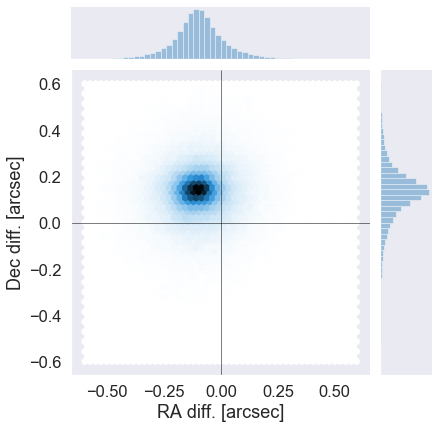

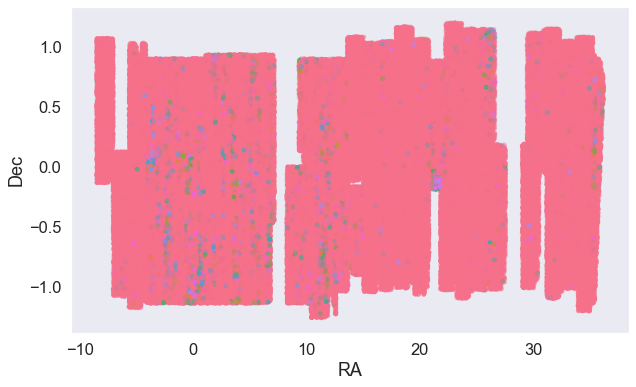

In [16]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [17]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.09985838245256673 arcsec
Dec correction: -0.13517424260163224 arcsec


In [20]:
catalogue[RA_COL] = catalogue[RA_COL]+ delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL]+delta_dec.to(u.deg)

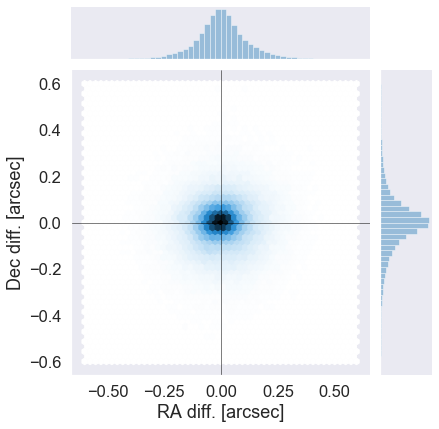

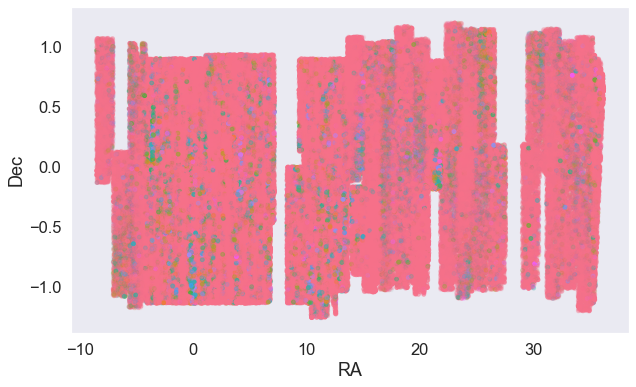

In [21]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [22]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [23]:
GAIA_FLAG_NAME = "vics82_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

194610 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [24]:
catalogue.write("{}/VICS82.fits".format(OUT_DIR), overwrite=True)